# Tabular Read-Write

This notebook is an introduction to the PAM tabular read-write methods. It has two parts:

1. [Read](#read-tabular-format)
2. [Write](#write-tabular-data)

In [1]:
import os

import pandas as pd

from pam import read

## Read Tabular Format

PAM can read from either tabular or MATSim formats. Tabular formats use the `pam.read.load_travel_diary` function, which will try to automatically infer trips and activities from commonly formatted travel diary data.

Tabular data should include a trips table and then optionally, atributes tables for persons and/or households. Tabular data is expected as pandas DataFrames with column names as described in the docs and/or as in the following example.

The following demonstration data is available in the [`data/example_data`](https://github.com/arup-group/pam/tree/main/examples/data/example_data) directory. All data paths in this example are relative to the [notebook directory](https://github.com/arup-group/pam/tree/main/examples) in the PAM repository.

#### Step 1

Load your trips (and attributes) data into pandas DataFrames. Reformat and rename the columns as required (please read the docs). The following example already has the required data types and column names:

**trips:**

Each row represents a trip, where:

- **pid**: person id of trip
- **hid**: household id of trip (**optional**)
- **seq**: sequence of trip within day (optional if order is already correct)
- **hzone**: home zone of person (**optional**)
- **ozone**: origin zone of trip
- **dzone**: destination zone of trip
- **purp**: purpose of trip (note that other ways of classifying purpose are supported - read the docs!)
- **mode**: trip mode
- **tst**: (integer) trip start time in minutes from start of day (typically from midnight)
- **tet**: (integer) trip end time as above
- **freq**: sample weighting (**optional**)

**persons:**

Each row represents a persons attributes. These can be arbitrary key - value pairs, with most types supported. The following are examples:

- **pid**: person id, must be consistent with trips data (**required**)
- gender: gender of person (example)
- job: employment status of person (example)
- occ: employment type of person (example)
- inc: income of person (example)

In [2]:
trips = pd.read_csv(
    os.path.join("data", "example_data", "example_travel_diaries.csv"), index_col="uid"
)
persons = pd.read_csv(
    os.path.join("data", "example_data", "example_attributes.csv"), index_col="pid"
)
trips.head(10)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
uid,,,,,,,,,,,
0,census_0,census_0,0,Harrow,Harrow,Camden,work,pt,444,473,1000
1,census_0,census_0,1,Harrow,Camden,Harrow,work,pt,890,919,1000
2,census_1,census_1,0,Greenwich,Greenwich,Tower Hamlets,work,pt,507,528,1000
3,census_1,census_1,1,Greenwich,Tower Hamlets,Greenwich,work,pt,1065,1086,1000
4,census_2,census_2,0,Croydon,Croydon,Croydon,work,pt,422,425,1000
5,census_2,census_2,1,Croydon,Croydon,Croydon,work,pt,917,920,1000
6,census_3,census_3,0,Haringey,Haringey,Redbridge,work,pt,428,447,1000
7,census_3,census_3,1,Haringey,Redbridge,Haringey,work,pt,1007,1026,1000
8,census_4,census_4,0,Hounslow,Hounslow,"Westminster,City of London",work,car,483,516,1000


In [3]:
persons.head(10)

,gender,job,occ,inc
pid,,,,
census_0,female,work,white,low
census_1,female,work,white,low
census_2,male,work,blue,high
census_3,male,work,blue,low
census_4,male,work,blue,medium
census_5,other,education,white,medium
census_6,female,work,blue,low
census_7,male,education,white,high
census_8,female,work,blue,medium


#### Step 2:

Load the travel diary data:

In [4]:
population = read.load_travel_diary(trips, persons, trip_freq_as_person_freq=True)

Using tour based purpose parser (recommended)
Adding pid->hh mapping to persons_attributes from trips.
Adding home locations to persons attributes using trips attributes.
Using freq of 'None' for all trips.


#### Step 3:

Check everything is as expected. PAM will try to infer activities from trip data, including for arbitrarily complex sequences of nested tours.

However, trip purpose can be encoded in a variety of ways. PAM will try to make sensible inference based on the data provided. If something looks wrong then check the docs, then consider raising an issue. The team are keen to support you!

In [5]:
household = population.households["census_12"]
person = household.people["census_12"]
person.print()

Person: census_12
{'gender': 'female', 'job': 'education', 'occ': 'white', 'inc': 'high', 'hzone': 'Croydon'}
0:	Activity(act:home, location:Croydon, time:00:00:00 --> 07:06:00, duration:7:06:00)
1:	Leg(mode:pt, area:Croydon --> Tower Hamlets, time:07:06:00 --> 07:45:00, duration:0:39:00)
2:	Activity(act:education, location:Tower Hamlets, time:07:45:00 --> 15:54:00, duration:8:09:00)
3:	Leg(mode:pt, area:Tower Hamlets --> Croydon, time:15:54:00 --> 16:33:00, duration:0:39:00)
4:	Activity(act:home, location:Croydon, time:16:33:00 --> 00:00:00, duration:7:27:00)


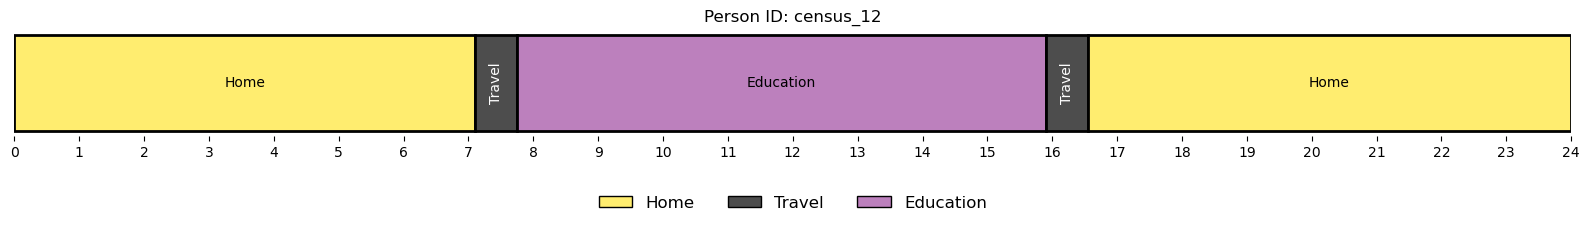

In [6]:
person.plot()

## Write Tabular Data

PAM can write into a preferred tabular formats using `pam.write.to_csv`. This outputs trip legs, household attributes and person attributes tables. Where sufficient geometries are found, PAM will write spatial data as geojson.

In [7]:
from pam import write

write.to_csv(population, dir="tmp")

PAM can also write directly to O-D matrices using `pam.write.write_od_matrices`. This can optionally be segmented (read the docs). But does not currently support trip weighting (frequency).


In [8]:
write.write_od_matrices(population, "tmp")

## Pickle

Not a tabular format but if you've read this far - you might like to know that there is a Population.pickle method:

In [9]:
population.pickle(os.path.join("tmp", "population.pickle"))